In [1]:
import librosa
import librosa.display

from scipy.signal import savgol_filter
from dotenv import load_dotenv

import os
import gc, time, datetime
from os import listdir, getenv

import matplotlib.pyplot as plt
import plotly.graph_objects as go

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

from torchvision.transforms import v2 as transforms
import torchvision.models as models

from torch.nn.functional import cosine_similarity
import torch.optim.lr_scheduler as lr_scheduler

# load the environment variables
load_dotenv()
PROJECT_PATH = getenv('PROJECT_PATH')

# set the path to music files
MUSIC_PATH = PROJECT_PATH + '/genre-clustering/previews/'
SPECTOGRAM_PATH = PROJECT_PATH + '/genre-clustering/spectograms/'
TRAINING_DATA_PATH = PROJECT_PATH + '/data/'

In [3]:
# convert previews into spectograms
filenames = listdir(MUSIC_PATH)[0:10]
mel_filter = True

for filename in filenames:
    y, sr = librosa.load(MUSIC_PATH + filename)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    if mel_filter:
        D = librosa.feature.melspectrogram(S=D, sr=sr)
    np.save(SPECTOGRAM_PATH + filename + ".npy", D)

# prepare data
filenames = listdir(SPECTOGRAM_PATH)
data = [np.load(SPECTOGRAM_PATH + filename) for filename in filenames]

In [4]:
def custom_hist(arr):
    labels, counts = np.unique(arr, return_counts=True)
    plt.bar(labels, counts, align='center')
    plt.gca().set_xticks(labels)
    plt.show()

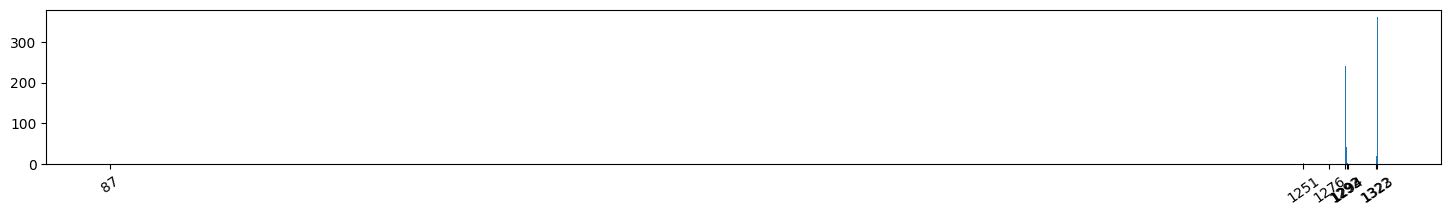

In [5]:
lengths = []
for i, spec in enumerate(data):
    lengths.append(spec.shape[1])
plt.figure(figsize=(18,2))
plt.xticks(rotation=35)
custom_hist(lengths)

In [6]:
# remove too short spectograms
remove_index = [147]
for idx in remove_index:
    data.pop(idx)

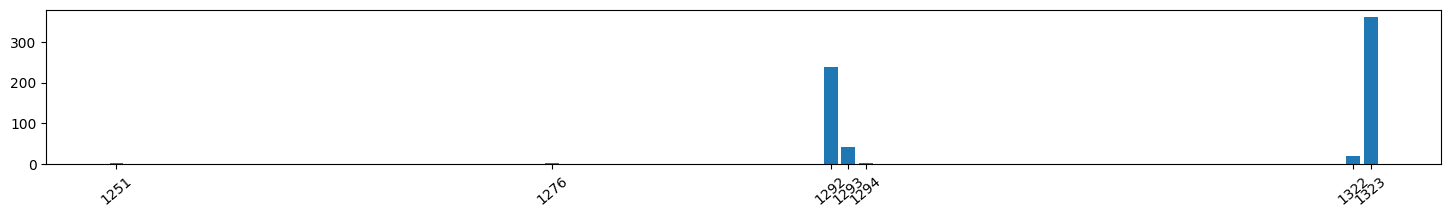

In [7]:
lengths = []
for i, spec in enumerate(data):
    lengths.append(spec.shape[1])
plt.figure(figsize=(18,2))
plt.xticks(rotation=40)
custom_hist(lengths)

In [8]:
# precision 
torch.set_default_dtype(torch.float64)

# set device to cuda
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.set_default_device(device); print("Device:", device)

Device: cuda


In [9]:
# bring data into right shape
data = torch.tensor(np.array([data[i][:, 0:np.min(lengths)] for i in range(len(data))]), dtype=torch.float64 ).unsqueeze(1).repeat(1,3,1,1)
print(f"Shape of data: {data[0].shape}")

Shape of data: torch.Size([3, 128, 1251])


In [10]:
def multi_normalize(dataset, val=(0,1)):
    for map in dataset:
        for i in range(3):
            map[i] = ((map[i] - map[i].min()) / (map[i].max() - map[i].min())) * np.abs(val[0] - val[1]) + val[0]

multi_normalize(data)

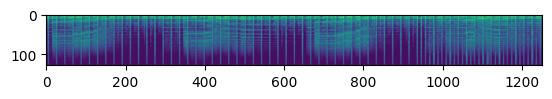

In [11]:
plt.imshow(data[333, 0, :, :].cpu());

In [12]:
class SpectralDataset(Dataset):
    
    def __init__(self, spectograms, transform, views, mb_size):
        self.data = transform(spectograms, views, mb_size)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
            return self.data[idx]

class SpectralTransforms(object):

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, data, n, mb_size):
        return torch.cat([torch.cat([self.transforms(data[mb_size*j:mb_size*(j+1)]) for i in range(n)]) for j in range(len(data) // mb_size)])

In [13]:
ten_second_crop = transforms.RandomResizedCrop(size=(128, 1323//3), antialias=False)
flip = transforms.RandomHorizontalFlip()

spectral_trafos = SpectralTransforms(transforms.Compose([ten_second_crop, flip]))

def shuffled_dataloader(minibatch_size):
    dataset = SpectralDataset(data[torch.randperm(data.shape[0])], spectral_trafos, 2, minibatch_size)
    dataloader = DataLoader(dataset, batch_size=minibatch_size*2, drop_last=True)
    return dataloader

## NUR ÄHNLICHKEITEN HERVORHEBEN

In [14]:
def loss_fn(repres, temp):
        
    # cosine similarity
    cos_sim = cosine_similarity(repres[:,None,:], repres[None,:,:], dim=-1)
        
    # mask out cosine similarity to itself
    self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
    cos_sim.masked_fill_(self_mask, -9e15)
    
    # positive examples
    pos_mask = torch.zeros(*cos_sim.shape, dtype=torch.bool).to('cuda')
    Identity = torch.eye(cos_sim.shape[0], dtype=torch.bool).to('cuda')
    
    pos_mask = pos_mask.masked_fill_(Identity, 0)
    pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0) 
        
    # negative examples
    neg_mask = pos_mask.logical_not()

    # nt-xent loss  
    nll = -cos_sim[pos_mask] / temp + torch.logsumexp(cos_sim[neg_mask] / temp, dim=-1)
    nll = nll.mean()

    
    return nll


In [15]:
def train_loop(dataloader, model, loss_fn, temp, optimizer, scheduler, logdata):
    size = len(dataloader.dataset) 
    
    for batch, X, in enumerate(dataloader):

        # compute representation and loss
        representations = model.forward(X)
        loss = loss_fn(representations, temp)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # log data      
        loss, current = loss.item(), (batch + 1) * len(X)
        logdata.append(loss)
        print(f"batch loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [16]:
model = models.resnet34() #torchvision.models.densenet121()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 
                                           'min', 
                                           factor=0.1, 
                                           patience=10, 
                                           cooldown=0,
                                           threshold=0.01,
                                           min_lr=1e-6)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer)

In [17]:
model.train()
epochs = 1
minibatch_size = 8
log = []

for epoch in range(epochs):
    time_delta = time.perf_counter()
    print(f"--- Epoch {epoch+1} -----------------------")

    # create training set and train model
    dataloader = shuffled_dataloader(minibatch_size)
    train_loop(dataloader, model, loss_fn, 0.7, optimizer, scheduler, log)

    # free some memory
    torch.cuda.empty_cache()
    gc.collect()

    # get a finnish time estimate
    time_estimate = datetime.datetime.now() + datetime.timedelta(seconds=(epochs - epoch - 1) * (time.perf_counter() - time_delta))
    print(f"time estimate: {str(time_estimate.time())[0:8]}")

# save model and loss
torch.save(model, TRAINING_DATA_PATH + 'model.pt')
np.save(TRAINING_DATA_PATH + 'loss.npy', log)

--- Epoch 1 -----------------------
batch loss: 5.417147  [   16/ 1328]
batch loss: 5.231954  [   32/ 1328]
batch loss: 4.724850  [   48/ 1328]
batch loss: 4.623953  [   64/ 1328]
batch loss: 4.402895  [   80/ 1328]
batch loss: 4.956182  [   96/ 1328]
batch loss: 4.905658  [  112/ 1328]
batch loss: 4.657992  [  128/ 1328]
batch loss: 5.049735  [  144/ 1328]
batch loss: 5.228927  [  160/ 1328]
batch loss: 4.839766  [  176/ 1328]
batch loss: 5.621540  [  192/ 1328]
batch loss: 4.720231  [  208/ 1328]
batch loss: 4.840000  [  224/ 1328]
batch loss: 4.726261  [  240/ 1328]
batch loss: 4.578810  [  256/ 1328]
batch loss: 4.794797  [  272/ 1328]
batch loss: 4.393917  [  288/ 1328]
batch loss: 4.650621  [  304/ 1328]
batch loss: 4.323807  [  320/ 1328]
batch loss: 4.284436  [  336/ 1328]
batch loss: 4.280003  [  352/ 1328]
batch loss: 4.303552  [  368/ 1328]
batch loss: 4.386559  [  384/ 1328]
batch loss: 4.235231  [  400/ 1328]
batch loss: 4.287390  [  416/ 1328]
batch loss: 4.666129  [  432

RuntimeError: Parent directory C:/Users/ldiep/Desktop/music-and-image-tagging/data does not exist.

In [ ]:
# execute if stoppt manually
torch.save(model,TRAINING_DATA_PATH + 'model.pt')
np.save(TRAINING_DATA_PATH + 'loss.npy', log)

In [ ]:
# plot with filter applied
plt.plot(log)
plt.plot(savgol_filter(log, window_length=20, polyorder=4))
plt.savefig(TRAINING_DATA_PATH + 'loss-plot.png')

In [ ]:
# load the saved model
model = torchvision.models.resnet34()
state_dict = torch.load(TRAINING_DATA_PATH + 'model.pt').state_dict()
model.load_state_dict(state_dict)
model.eval();

# evaluate it
reduced_data = model.forward(data[0:400]).numpy(force=True)
np.save('data/reduced_data.npy', reduced_data)